In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D


import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
model_n = 0
task_list = ['fdgo','fdanti','delaygo','delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = '4_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','task_schematic_multitask','figs','interp_fps',file_spec,str(model_n))
if not os.path.exists(figpath):
    os.makedirs(figpath)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [65]:
### SUBSPACE ANGLES w INTRINSIC SUBSPACE ###
from scipy.linalg import subspace_angles

h,trial,tasks = make_h_trial_rule(m_all,mode = 'test')
epoch_set = ['stim1','go1']
task_reorder = [0,2,1,3]
n_comp = 2
n_task = len(tasks)
sa_set = np.empty((len(epoch_set),n_task,n_task,n_comp))

for ria in range(n_task):
    rule_a = tasks[ria]
    Beta_a = generate_Beta_epoch(h[rule_a],trial[rule_a],ind = -1)

    for rib in range(n_task): 
        rule_b = tasks[rib]
        Beta_b = generate_Beta_epoch(h[rule_b],trial[rule_b],ind = -1)

        for epoch_ind in range(len(epoch_set)):

            epoch = epoch_set[epoch_ind]
            sa_set[epoch_ind,task_reorder[ria],task_reorder[rib],:] = subspace_angles(Beta_a[epoch], Beta_b[epoch])

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


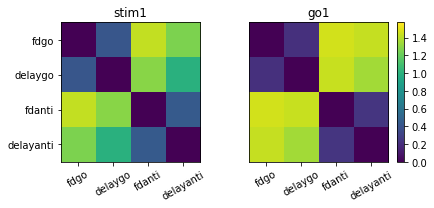

In [66]:
fig = plt.figure(figsize=(6.5,3),tight_layout=True,facecolor='white')
task_order = [task_list[i] for i in task_reorder] 

for epoch_ind in range(len(epoch_set)):
    
    epoch = epoch_set[epoch_ind]
    plt.subplot(1,len(epoch_set),epoch_ind+1)
    plt.imshow(np.mean(sa_set[epoch_ind,:,:,:],axis = 2),clim = [0,np.pi/2])
    plt.xticks(np.arange(len(task_reorder)),task_order,rotation = 30)
    if epoch_ind==0:
        plt.yticks(np.arange(len(task_reorder)),task_order)
    else:
        plt.yticks([])
            
    plt.title(epoch)
    
plt.colorbar()
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


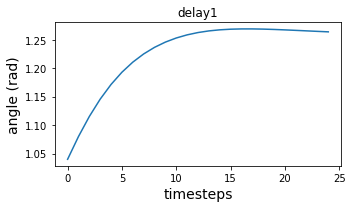

In [61]:
### SUBSPACE ANGLES w INTRINSIC SUBSPACE ###
from scipy.linalg import subspace_angles

h,trial,tasks = make_h_trial_rule(m_all,mode = 'test')
epoch = 'delay1'
task_reorder = [2,3]
n_comp = 2
n_task = len(task_reorder)
t_inds = range(25)
sa_set = np.empty((len(t_inds),n_task,n_task,n_comp))

for t_ind in t_inds:
    for ria_i in range(len(task_reorder)):
        ria = task_reorder[ria_i]
        rule_a = tasks[ria]
        Beta_a = generate_Beta_epoch(h[rule_a],trial[rule_a],ind = t_ind)

        for rib_i in range(len(task_reorder)):
            rib = task_reorder[rib_i]
            rule_b = tasks[rib]
            Beta_b = generate_Beta_epoch(h[rule_b],trial[rule_b],ind = t_ind)

            sa_set[t_ind,ria_i,rib_i,:] = subspace_angles(Beta_a[epoch], Beta_b[epoch])
            
fig = plt.figure(figsize=(5,3),tight_layout=True,facecolor='white')
plt.plot(np.mean(sa_set[:,0,1,:],axis = 1))
plt.title(epoch)
plt.xlabel('timesteps',fontsize = 14)
plt.ylabel('angle (rad)',fontsize = 14)
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


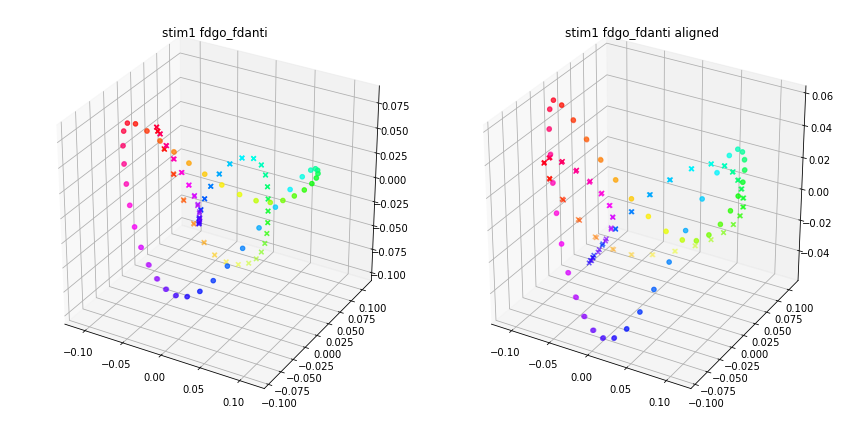

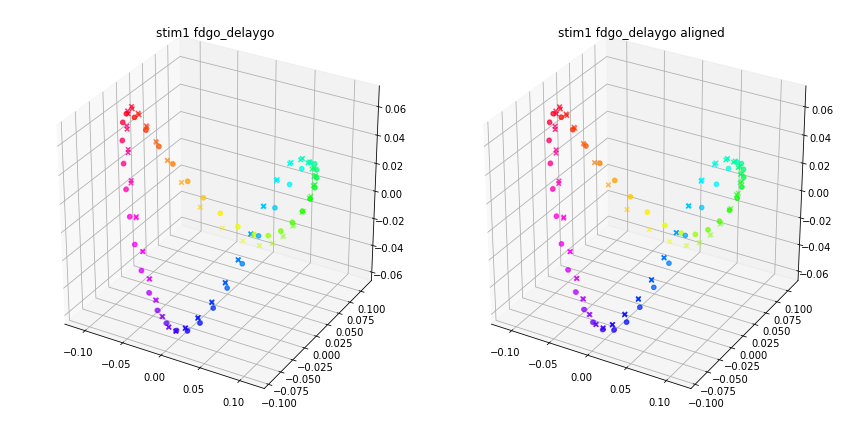

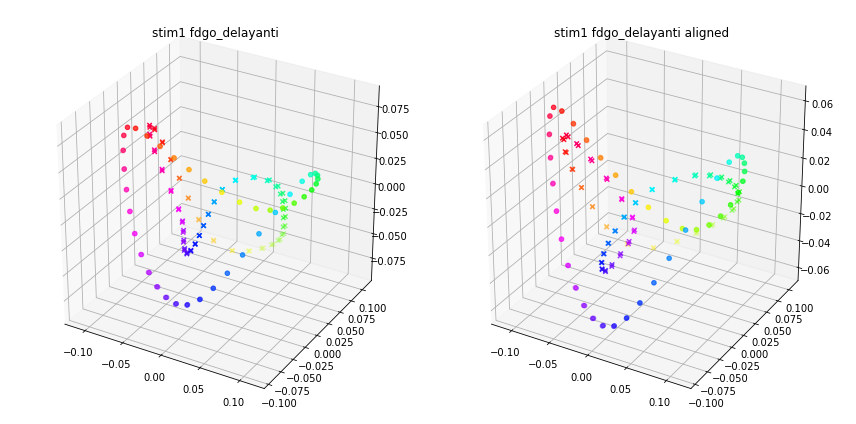

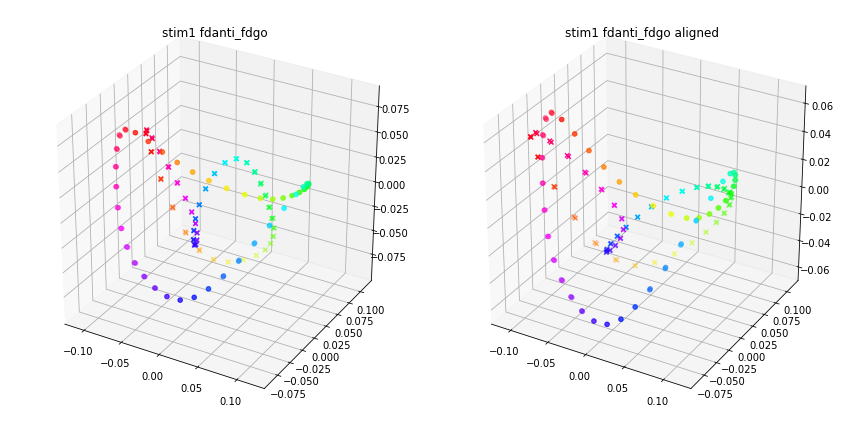

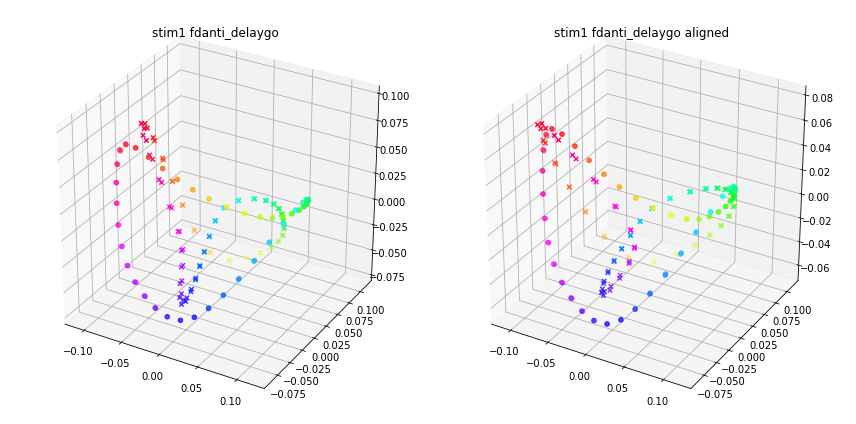

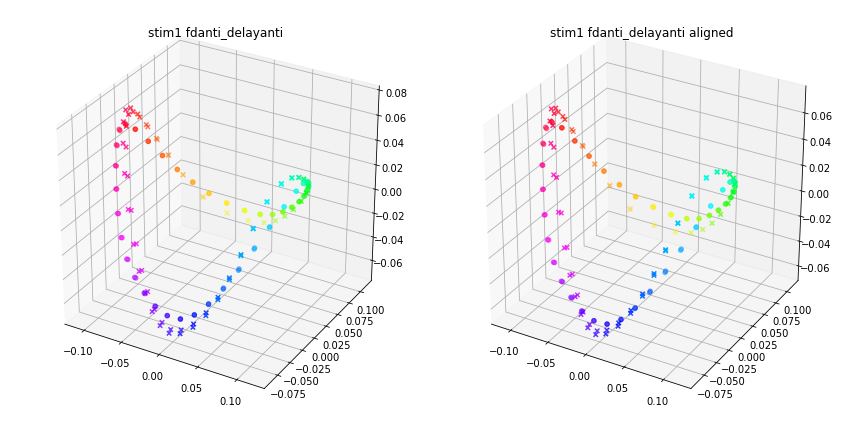

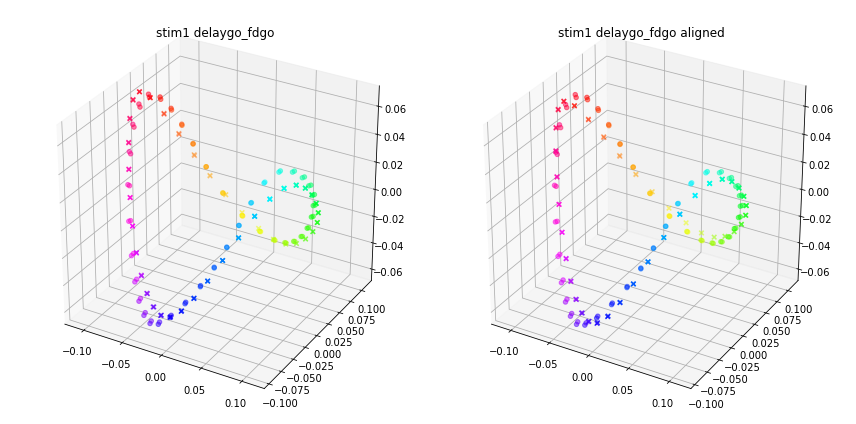

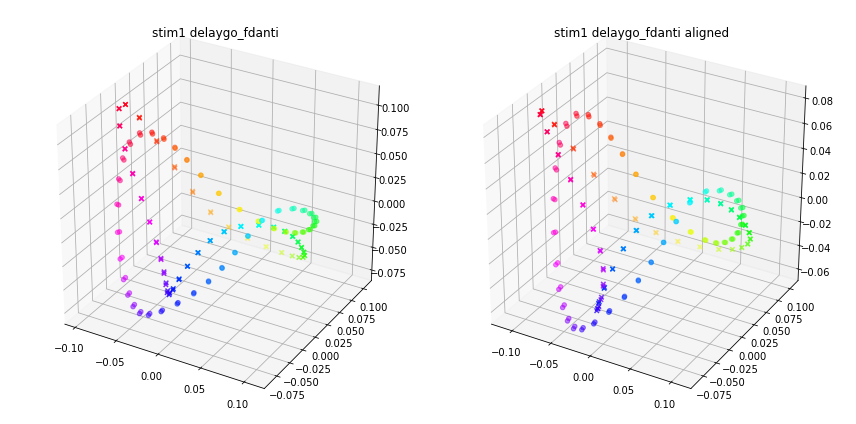

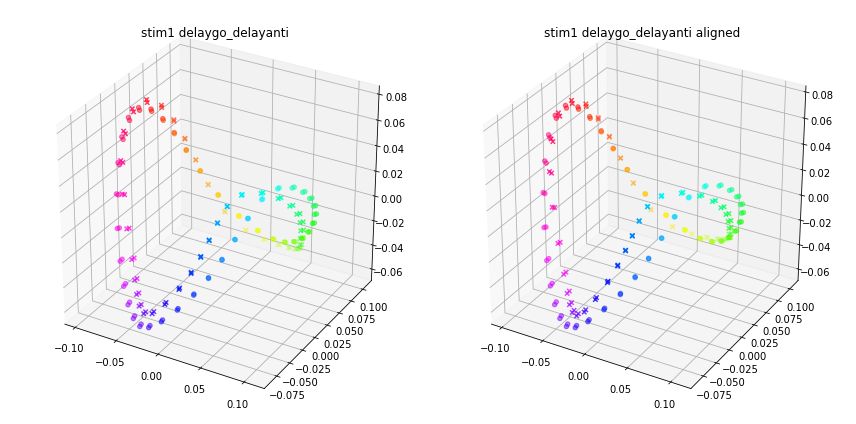

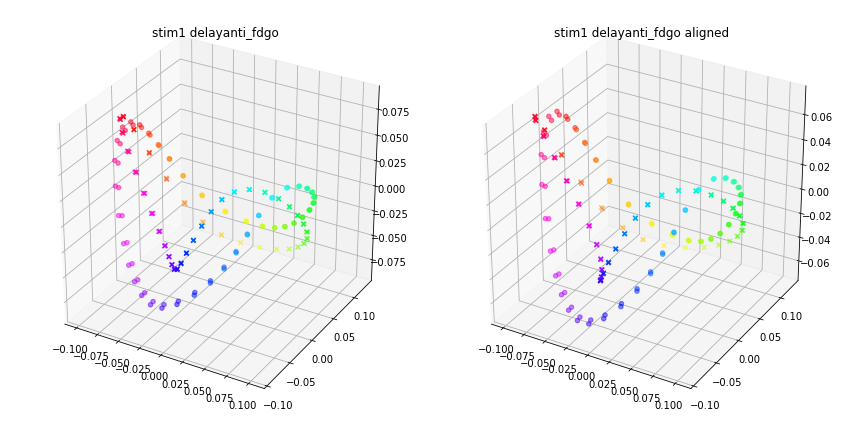

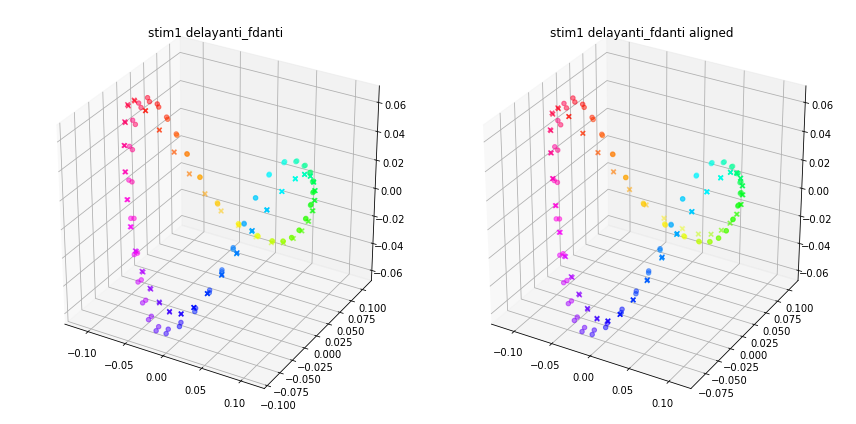

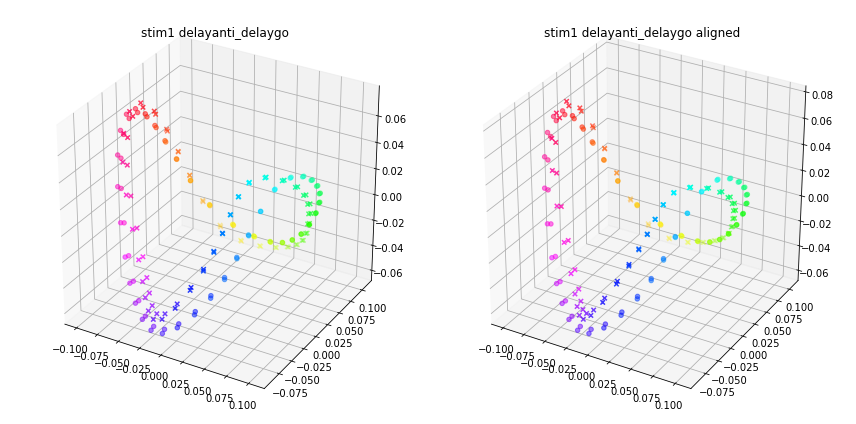

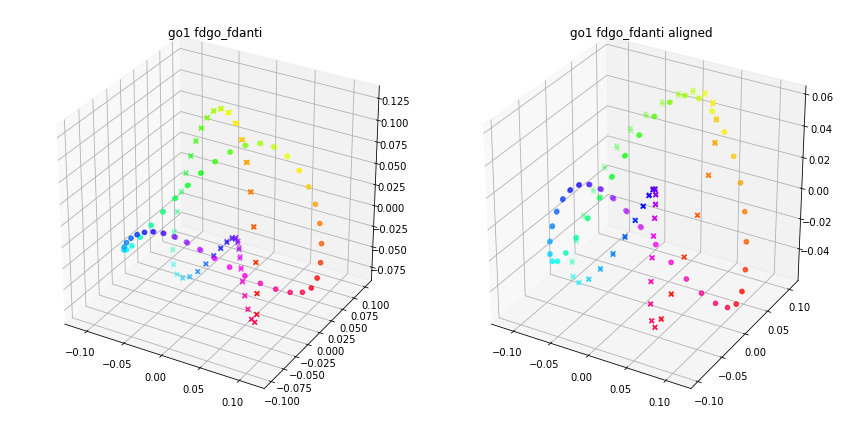

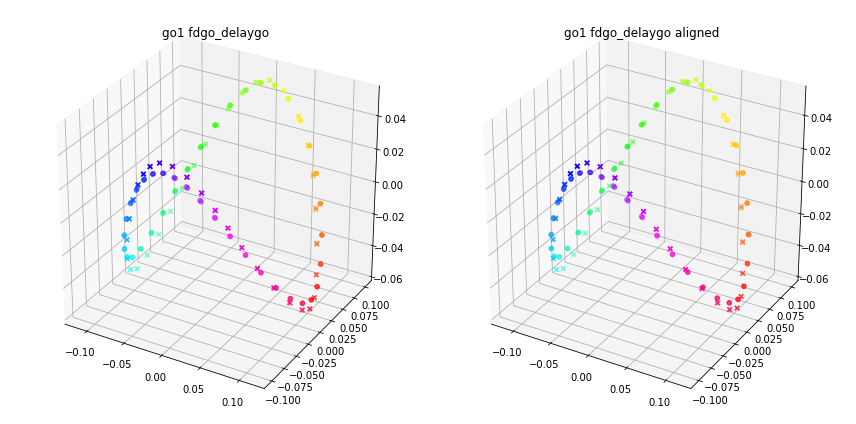

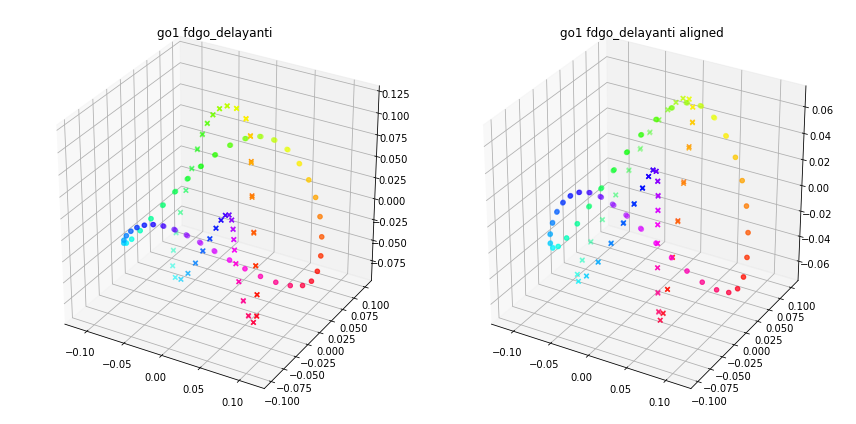

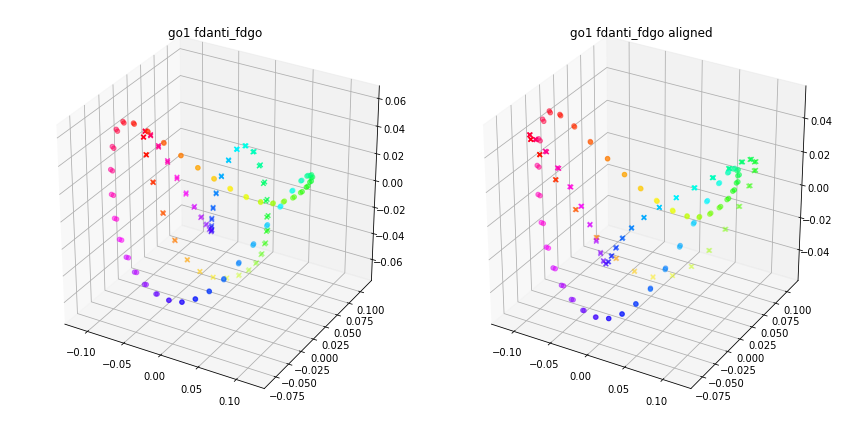

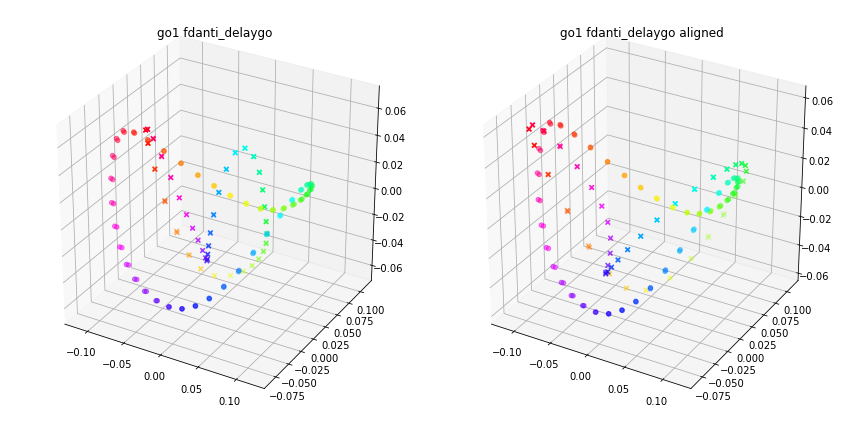

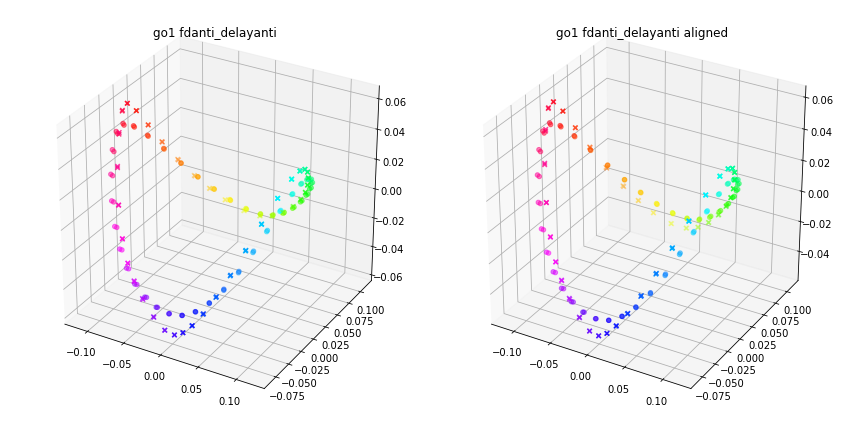

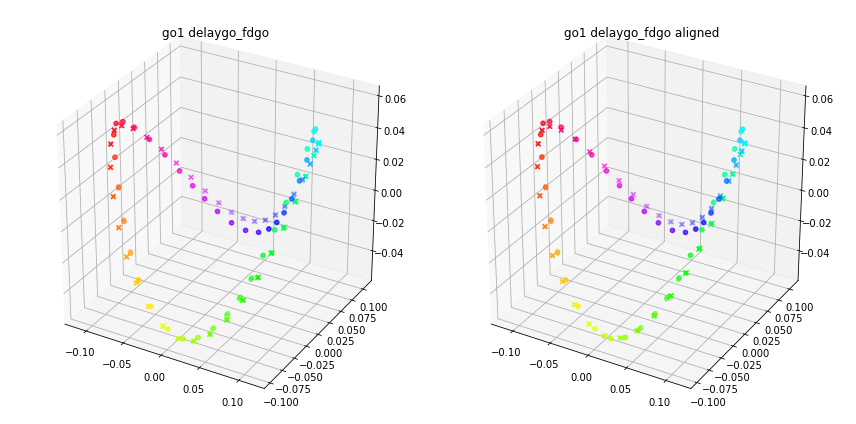

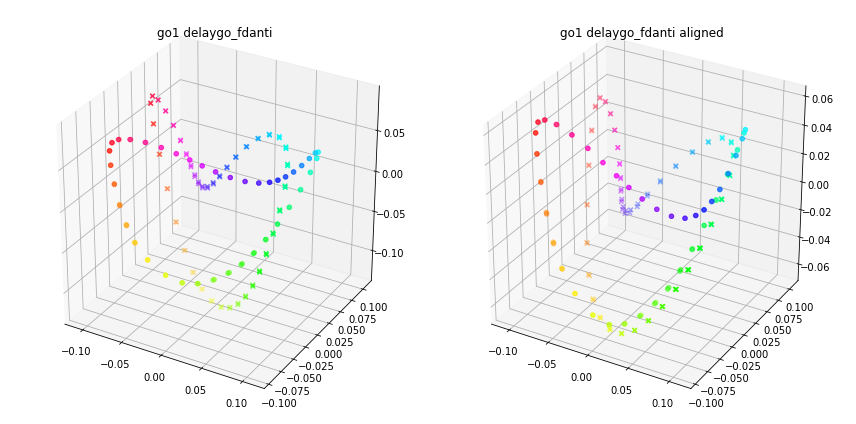

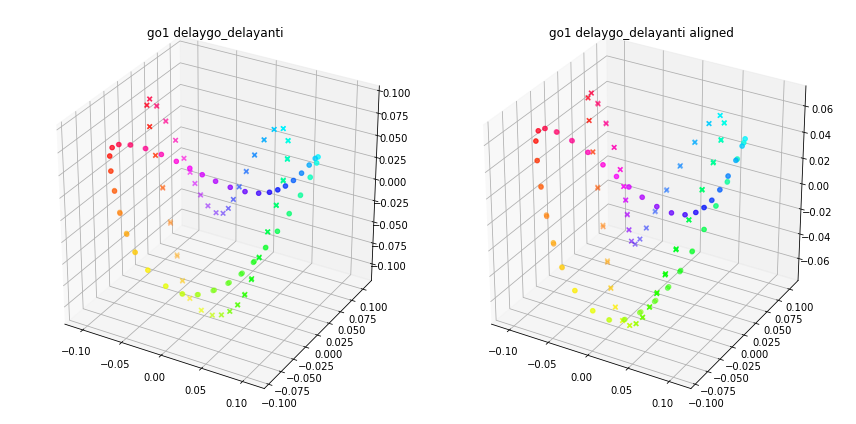

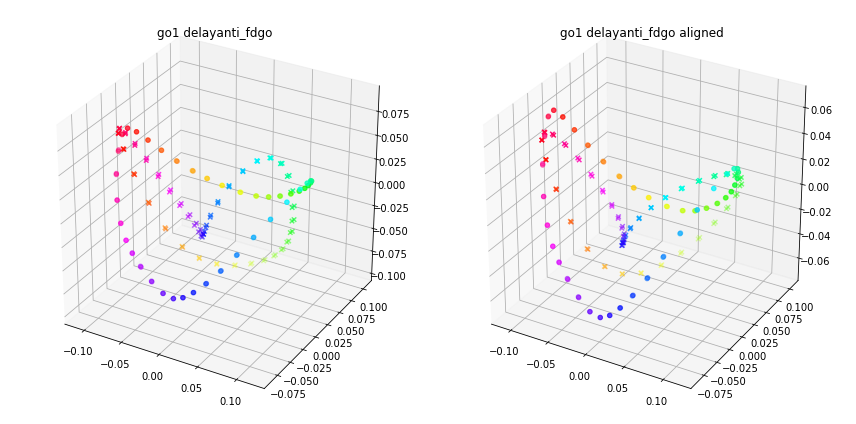

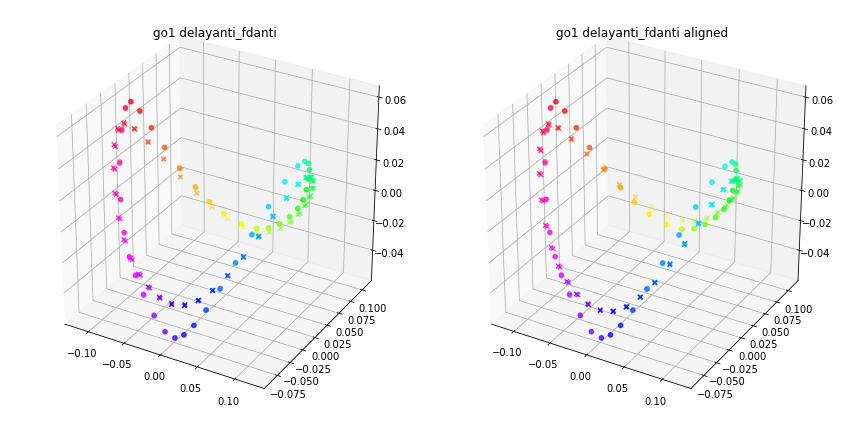

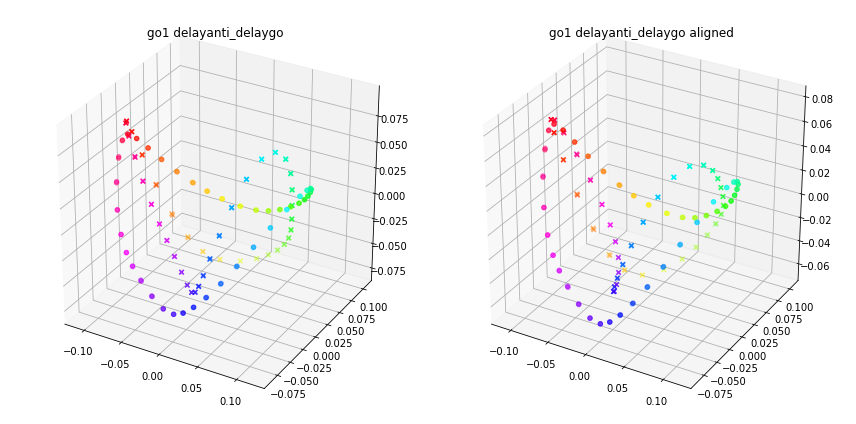

In [72]:
### SUBSPACE ANGLES w INTRINSIC SUBSPACE ###
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from tools_lnd import procrustes_fit,prep_procrustes,procrustes_test

h,trial,tasks = make_h_trial_rule(m_all,mode = 'test',noise_on = False)
epoch_set = ['stim1','go1']
task_reorder = [0,2,1,3]
n_comp = 2
n_task = len(tasks)
nD = 5
sa_set = np.empty((len(epoch_set),n_task,n_task,nD))
procustes_set = {}
procustes_set['disparity'] = np.empty((len(epoch_set),n_task,n_task))
procustes_set['R'] = np.empty((len(epoch_set),n_task,n_task,nD,nD))

for epoch_ind in range(len(epoch_set)):

    epoch = epoch_set[epoch_ind]
            
    for ria in range(n_task):
        rule_a = tasks[ria]
        T_inds = get_T_inds(trial[rule_a],epoch)
        full_data1 = h[rule_a][T_inds[-1],:,:]
        pca = PCA(n_components = nD)
        pca_data1 = pca.fit_transform(full_data1)

        for rib in range(n_task):
            rule_b = tasks[rib]
            T_inds = get_T_inds(trial[rule_b],epoch)
            full_data2 = h[rule_b][T_inds[-1],:,:]
    #         pca = PCA(n_components = nD)
            pca_data2 = pca.transform(full_data2) #pca_data2 = pca.fit_transform(full_data2)

            mtx1,mtx2 = prep_procrustes(pca_data1, pca_data2)
            _, _, disparity, R, s = procrustes_fit(mtx1, mtx2)
            mtx1, mtx2_aligned, disparity = procrustes_test(mtx1, mtx2, R, s)

            if ria!=rib:
                fig = plt.figure(figsize=(12,6),tight_layout=True,facecolor='white')
                ax = fig.add_subplot(121, projection='3d')
                ax.scatter3D(mtx1[:,0],mtx1[:,1],mtx1[:,2],c = range(np.shape(mtx1)[0]),cmap = 'hsv',alpha = .5)
                ax.scatter3D(mtx2[:,0],mtx2[:,1],mtx2[:,2],marker = 'x',c = range(np.shape(mtx1)[0]),cmap = 'hsv')
                plt.title(epoch + ' ' + rule_a+'_'+rule_b)

                ax = fig.add_subplot(122, projection='3d')
                ax.scatter3D(mtx1[:,0],mtx1[:,1],mtx1[:,2],c = range(np.shape(mtx1)[0]),cmap = 'hsv',alpha = .5)
                ax.scatter3D(mtx2_aligned[:,0],mtx2_aligned[:,1],mtx2_aligned[:,2],marker = 'x',c = range(np.shape(mtx1)[0]),cmap = 'hsv')
                plt.title(epoch + ' ' + rule_a + '_' + rule_b + ' aligned')
                plt.show()

            procustes_set['disparity'][epoch_ind,task_reorder[ria],task_reorder[rib]] = disparity
            procustes_set['R'][epoch_ind,task_reorder[ria],task_reorder[rib],:,:] = R
            sa_set[epoch_ind,task_reorder[ria],task_reorder[rib],:] = subspace_angles(pca_data1, pca_data2)

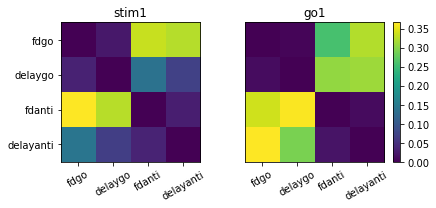

In [73]:
fig = plt.figure(figsize=(6.5,3),tight_layout=True,facecolor='white')
task_order = [task_list[i] for i in task_reorder] 

for epoch_ind in range(len(epoch_set)):
    
    epoch = epoch_set[epoch_ind]
    plt.subplot(1,len(epoch_set),epoch_ind+1)
    plt.imshow(procustes_set['disparity'][epoch_ind,:,:])
    plt.xticks(np.arange(len(task_reorder)),task_order,rotation = 30)
    if epoch_ind==0:
        plt.yticks(np.arange(len(task_reorder)),task_order)
    else:
        plt.yticks([])
            
    plt.title(epoch)
    
plt.colorbar()
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


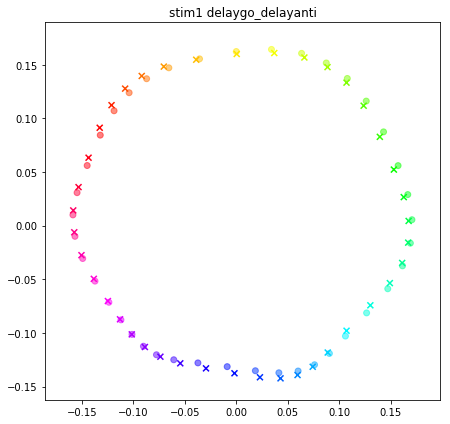

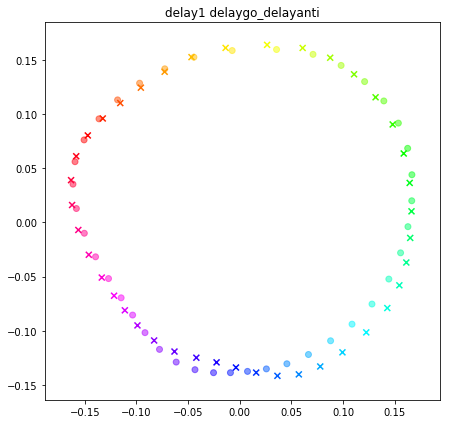

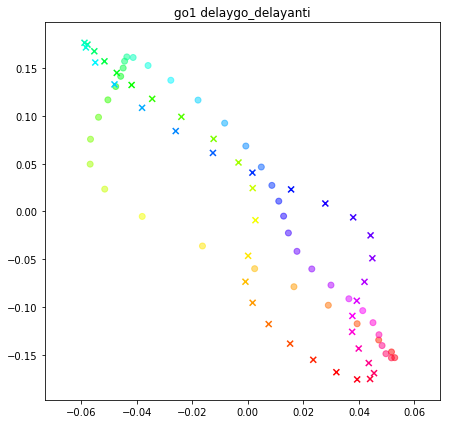

In [59]:
### SUBSPACE ANGLES w INTRINSIC SUBSPACE ###
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from tools_lnd import procrustes_fit,prep_procrustes,procrustes_test

h,trial,tasks = make_h_trial_rule(m_all,mode = 'test',noise_on = False)
epoch_set = ['stim1','delay1','go1']
task_reorder = [0,2,1,3]
n_comp = 2
n_task = len(tasks)
nD = 3
sa_set = np.empty((len(epoch_set),n_task,n_task,nD))
procustes_set = {}
procustes_set['disparity'] = np.empty((len(epoch_set),n_task,n_task))
procustes_set['R'] = np.empty((len(epoch_set),n_task,n_task,nD,nD))
ria = 2
rib = 3
trials_use = range(0,80,2)
    

for epoch_ind in range(len(epoch_set)):

    epoch = epoch_set[epoch_ind]

    rule_a = tasks[ria]
    T_inds = get_T_inds(trial[rule_a],epoch)
    full_data1 = h[rule_a][T_inds[-1],trials_use,:]
    pca = PCA(n_components = nD)
    

    rule_b = tasks[rib]
    T_inds = get_T_inds(trial[rule_b],epoch)
    full_data2 = h[rule_b][T_inds[-1],trials_use,:]
#         pca = PCA(n_components = nD)

    _ = pca.fit_transform(np.concatenate((full_data1,full_data2),axis = 0))
    pca_data1 = pca.transform(full_data1) #pca_data2 = pca.fit_transform(full_data2)
    pca_data2 = pca.transform(full_data2) #pca_data2 = pca.fit_transform(full_data2)

    mtx1,mtx2 = prep_procrustes(pca_data1, pca_data2)
    _, _, disparity, R, s = procrustes_fit(mtx1, mtx2)
    mtx1, mtx2_aligned, disparity = procrustes_test(mtx1, mtx2, R, s)

    if ria!=rib:
        fig = plt.figure(figsize=(12,6),tight_layout=True,facecolor='white')
        ax = fig.add_subplot(121)
        
        clist = np.min(trial[rule_a].stim_locs[:,[0,2]],axis=1)
#         clist = trial[rule_a].y_loc[-1,:]
        ax.scatter(mtx1[:,0],mtx1[:,1],c = clist[trials_use],cmap = 'hsv',alpha = .5)
        
        clist = np.min(trial[rule_b].stim_locs[:,[0,2]],axis=1)
#         clist = trial[rule_b].y_loc[-1,:]
        ax.scatter(mtx2[:,0],mtx2[:,1],marker = 'x',c = clist[trials_use],cmap = 'hsv')
        plt.title(epoch + ' ' + rule_a+'_'+rule_b)


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


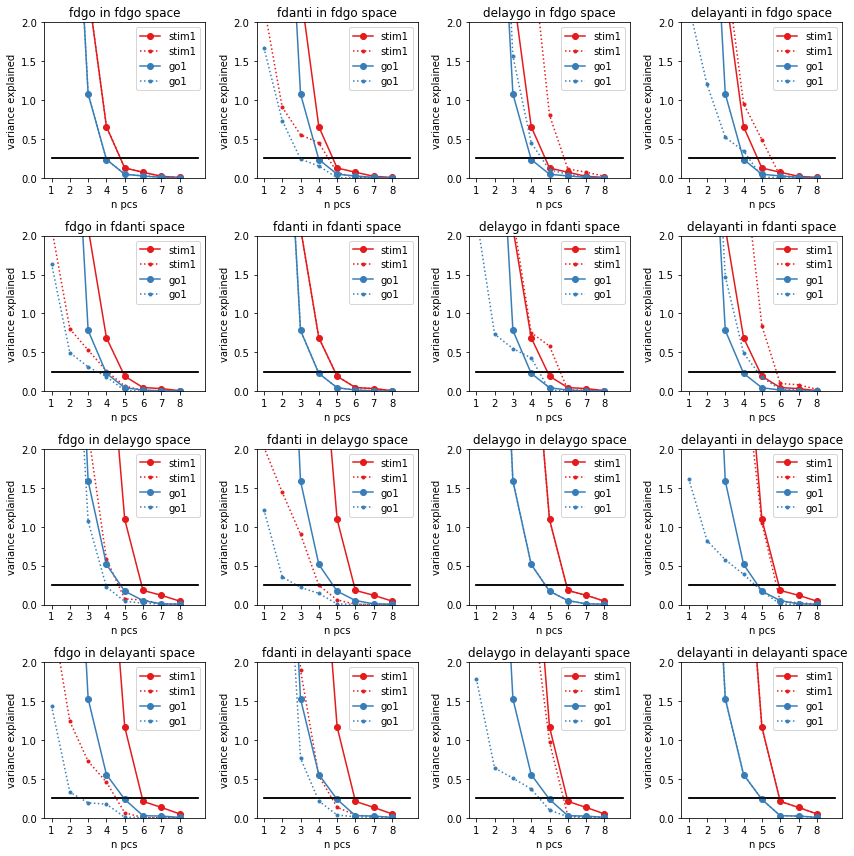

In [90]:
### SUBSPACE ANGLES w INTRINSIC SUBSPACE ###
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from tools_lnd import procrustes_fit,prep_procrustes,procrustes_test


h,trial,tasks = make_h_trial_rule(m_all,mode = 'test',noise_on = False)
tasks = ['delaygo','delayanti']
tasks = ['fdgo','fdanti','delaygo','delayanti']
epoch_set = ['stim1','go1']
task_reorder = [0,2,1,3]
n_comp = 2
n_task = len(tasks)
nD = 8
sa_set = np.empty((len(epoch_set),n_task,n_task,nD))
procustes_set = {}
procustes_set['disparity'] = np.empty((len(epoch_set),n_task,n_task))
procustes_set['R'] = np.empty((len(epoch_set),n_task,n_task,nD,nD))
ria = 2
rib = 3
trials_use = range(0,80,2)
cmap = plt.get_cmap('Set1')

fig = plt.figure(figsize=(12,12),tight_layout=True,facecolor='white')


for ria in range(n_task):
    for rib in range(n_task):
#         if ria==rib:
    
        for epoch_ind in range(len(epoch_set)):

            ax = plt.subplot(n_task,n_task,ria*n_task+1+rib)
            epoch = epoch_set[epoch_ind]

            rule_a = tasks[ria]
            T_inds = get_T_inds(trial[rule_a],epoch)
            full_data1 = h[rule_a][T_inds[-1],trials_use,:]
            pca = PCA(n_components = nD)
            pca_data1 = pca.fit_transform(full_data1)

            ve1 = np.sort(LA.eig(np.cov(pca_data1.T))[0])
            ve_ratio = ve1[::-1]#/sum(ve1)
            plt.plot(ve_ratio,'o-',color = cmap(epoch_ind/5),label = epoch)

            rule_b = tasks[rib]
            T_inds = get_T_inds(trial[rule_b],epoch)
            full_data2 = h[rule_b][T_inds[-1],trials_use,:]
            pca_data2 = pca.transform(full_data2) #pca_data2 = pca.fit_transform(full_data2)

            ve2 = np.sort(LA.eig(np.cov(pca_data2.T))[0])
            ve_ratio = ve2[::-1]#/sum(ve1)
            plt.plot(ve_ratio,'.:',color = cmap(epoch_ind/5),label = epoch)
            plt.plot([0,nD],[.25,.25],'-k')

        plt.xticks(range(nD),range(1,nD+1))
        plt.xlabel('n pcs')
        plt.ylabel('variance explained')
        plt.ylim((0,2))
        plt.title(rule_b +' in '+rule_a +' space')
        plt.legend()

In [76]:
trial = {}
h = {}
task_set = tasks
mode = 'test'
noise_on = 'True'

model = Model(m_all)
with tf.Session() as sess:

    model.restore()#model.saver.restore(sess,ckpt_n_dir)
    # model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hp = model.hp

    if len(task_set)==0:
        task_set = hp['rule_trains']

    for rule in task_set:
        trial[rule] = generate_trials(rule, hp, mode,
                        batch_size=400, delay_fac=hp['delay_fac'],noise_on = noise_on)

        # Generating feed_dict.
        feed_dict = tools.gen_feed_dict(model, trial[rule], hp)
        h[rule] = sess.run(model.h, feed_dict=feed_dict)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


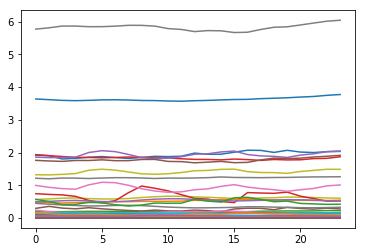

In [81]:
rule_a = 'delaygo'
epoch = 'delay1'
T_inds = get_T_inds(trial[rule_a],epoch)
plt.plot(h[rule_a][T_inds[25:-1],0,:])
plt.show()

In [85]:
np.mean(np.var(h[rule_a][T_inds[25:-1],0,:]))

0.25388232